# Client orders :: *ipynb solution draft* <br>

## Read Data

In [11]:
# Import libraries

import order_functions as of

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re

from persiantools import jdatetime

from scipy.stats import boxcox
from scipy.stats import ttest_ind

from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
# Read data / Clean version of sales_data.csv

df = pd.read_csv("sales_data_clean.csv")
df.head()

,Order_ID,Branch,Order_Date,Order_Priority,Manufacturer,Model_Name,Category,Screen_Size,RAM,OS,...,CPU_GHZ,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,Storage_Total,GPU_Brand,GPU_Model,Rating,Store
0,0,Hamedan,1396-10-26,H,Dell,Vostro 3568,Notebook,15.6,8,Windows,...,2.5,256,0,0,0,256,AMD,Radeon R5 M420,NaN,NaN
1,1,Kermanshah,1394-04-21,H,Lenovo,Yoga 720-13IKB,2 in 1 Convertible,13.3,8,Windows,...,2.5,256,0,0,0,256,Intel,HD Graphics 620,NaN,NaN
2,2,Rasht,1402-05-24,M,Lenovo,IdeaPad Y700-15ISK,Notebook,15.6,8,Windows,...,2.6,0,1024,0,0,1024,Nvidia,GeForce GTX 960M,NaN,NaN
3,3,Kermanshah,1397-06-17,H,Dell,Inspiron 5370,Ultrabook,13.3,8,Windows,...,1.8,256,0,0,0,256,AMD,Radeon 530,NaN,NaN
4,4,Karaj,1392-09-30,L,Acer,Aspire E5-576G,Notebook,15.6,4,Windows,...,2.5,256,0,0,0,256,Nvidia,GeForce 940MX,NaN,NaN


In [13]:
# Convert Shamsi dates to Miladi

def vectorized_convert_shamsi_to_datetime(years, months, days):
    gregorian_dates = [
        jdatetime.JalaliDate(int(y), int(m), int(d)).to_gregorian()
        for y, m, d in zip(years, months, days)
    ]
    return pd.to_datetime(gregorian_dates)

years, months, days = zip(*df["Order_Date"].str.split("-").tolist())
df["Order_Date"] = vectorized_convert_shamsi_to_datetime(years, months, days)
df.head()

,Order_ID,Branch,Order_Date,Order_Priority,Manufacturer,Model_Name,Category,Screen_Size,RAM,OS,...,CPU_GHZ,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,Storage_Total,GPU_Brand,GPU_Model,Rating,Store
0,0,Hamedan,2018-01-16,H,Dell,Vostro 3568,Notebook,15.6,8,Windows,...,2.5,256,0,0,0,256,AMD,Radeon R5 M420,NaN,NaN
1,1,Kermanshah,2015-07-12,H,Lenovo,Yoga 720-13IKB,2 in 1 Convertible,13.3,8,Windows,...,2.5,256,0,0,0,256,Intel,HD Graphics 620,NaN,NaN
2,2,Rasht,2023-08-15,M,Lenovo,IdeaPad Y700-15ISK,Notebook,15.6,8,Windows,...,2.6,0,1024,0,0,1024,Nvidia,GeForce GTX 960M,NaN,NaN
3,3,Kermanshah,2018-09-08,H,Dell,Inspiron 5370,Ultrabook,13.3,8,Windows,...,1.8,256,0,0,0,256,AMD,Radeon 530,NaN,NaN
4,4,Karaj,2013-12-21,L,Acer,Aspire E5-576G,Notebook,15.6,4,Windows,...,2.5,256,0,0,0,256,Nvidia,GeForce 940MX,NaN,NaN


---

## Client Order #2

از آنجایی که شرکت دوباره شروع به کار کرده است می‌خواهد ببیند آیا تخفیف رو‌ی میزان فروش تاثیر دارد؟ و نحوه تاثیر یا عدم تاثیر را نمایش دهید.

**Hypothesis**: <br>
"Discount has a significant impact on the sales of laptop.” <br><br>

Null Hypothesis (**H<sub>0</sub>**): Discount has no significant impact on the sales of laptop. <br>
Alternative Hypothesis (**H<sub>a</sub>**): Discount has a significant impact on the sales of laptop.

In [14]:
# Filter coumns needed for analyze

cols_for_analyze_2 = [
    "Discount",
    "Total_Price",
]
df2 = df[cols_for_analyze_2].copy()

df2["Discount_Applied"] = df2["Discount"] > 0

df2.head()

,Discount,Total_Price,Discount_Applied
0,0,3450000,False
1,0,3400000,False
2,0,44900000,False
3,0,12550000,False
4,0,2050000,False


In [15]:
# Calculate average sales by discount

average_sales_by_discount = df2.groupby("Discount_Applied")["Total_Price"].mean()

average_sales_by_discount

Discount_Applied
False    1.455367e+07
True     1.393049e+07
Name: Total_Price, dtype: float64

Average Total Price without discount    =   14_553_670  IRT <br>
Average Total Price with discount       =   13_930_490  IRT <br>

**Doesn't provide enough evidence**

In [16]:
# Split data into two groups: with discount and without discount

df_with_discount = pd.DataFrame(df2[df2["Discount_Applied"] == True]["Total_Price"])
df_without_discount = pd.DataFrame(df2[df2["Discount_Applied"] == False]["Total_Price"])

In [17]:
# Define function to plot two histograms above each other with mean values

def create_double_histogram(df1, df2, df1_label, df2_label, title, column_name="price"):
    mean_1 = df1[column_name].mean()
    mean_2 = df2[column_name].mean()

    plt.figure(figsize=(7, 5))
    sns.histplot(data=df1, x=column_name, color="blue", kde=True, label=df1_label)
    sns.histplot(data=df2, x=column_name, color="red", kde=True, label=df2_label)

    mean_text_y = plt.ylim()[1] / 2

    plt.axvline(mean_1, color="blue", linestyle="--")
    plt.text(mean_1, mean_text_y, f"{mean_1:,.2}", rotation=0, color="blue")

    plt.axvline(mean_2, color="red", linestyle="--")
    plt.text(mean_2, mean_text_y + 50, f"{mean_2:,.2}", rotation=0, color="red")

    plt.title(title, loc="center")
    plt.legend()
    plt.tight_layout()
    plt.show()

Skewness for applied discount sales: 3.65
Skewness for non-applied discount sales: 3.45


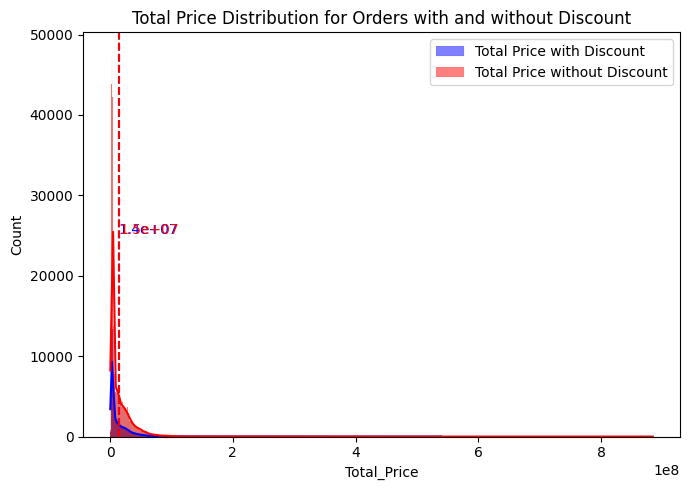

In [18]:
# Measure skewness for each group
# Plot the histogram for the final dataframes

skewness_total_price_with_discount = df_with_discount["Total_Price"].skew()
skewness_total_price_without_discount = df_without_discount["Total_Price"].skew()

print(f"Skewness for applied discount sales: {skewness_total_price_with_discount:,.2f}")
print(f"Skewness for non-applied discount sales: {skewness_total_price_without_discount:,.2f}")

create_double_histogram(
    df_with_discount,
    df_without_discount,
    "Total Price with Discount",
    "Total Price without Discount",
    title="Total Price Distribution for Orders with and without Discount",
    column_name="Total_Price",
)

Skewness for applied discount sales after boxcox transform: 0.06
Skewness for non-applied discount sales after boxcox transform: 0.06


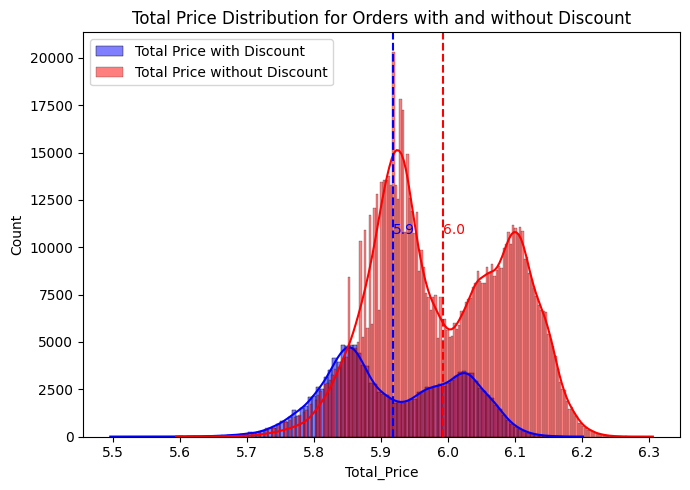

In [19]:
# Apply BOXCOX transformation on both groups
# Measure skewness for each group
# Plot the histogram for the final dataframes

df_with_discount["Total_Price"], _ = boxcox(df_with_discount["Total_Price"])
df_without_discount["Total_Price"], _ = boxcox(df_without_discount["Total_Price"])

skewness_total_price_with_discount = df_with_discount["Total_Price"].skew()
skewness_total_price_without_discount = df_without_discount["Total_Price"].skew()

print(f"Skewness for applied discount sales after boxcox transform: {skewness_total_price_with_discount:,.2f}")
print(f"Skewness for non-applied discount sales after boxcox transform: {skewness_total_price_without_discount:,.2f}")

create_double_histogram(
    df_with_discount,
    df_without_discount,
    "Total Price with Discount",
    "Total Price without Discount",
    title="Total Price Distribution for Orders with and without Discount",
    column_name="Total_Price",
)

In [20]:
# Apply t-test to check if the difference between two groups is significant

t_stat, p_value = ttest_ind(
    df_with_discount["Total_Price"], df_without_discount["Total_Price"]
)
print(f"t-statistic: {t_stat:.5f}")
print(f"p-value: {p_value:.20}")

t-statistic: -269.81477
p-value: 0.0


> P-Valye << **0.000** indicates that the observed data is extremely inconsistent with the null hypothesis. <br>
> T-STAT < **0** indicates increasing dicount rate relates to decreasing the sale but it can mean different things. <br>
    For instance, if the goal of the discount was to clear out old stock, then even if the revenue was lower with discounts, the strategy might still be deemed successful. <br><br>
> This leads to the **REJECTION** of the null hypothesis(H<sub>0</sub>) in favor of the alternative hypothesis (H<sub>a</sub>). <br><br>
> **This suggests that based on the data, there is very strong evidence to conclude that applying discount on laptop sales has a significant impact on the Total Sale Value.**

---